## Data Processing and Visualization

This notebook describes the processing and visualization of performance data of different algorithms executed on different devices. 

The data is obtained from two CSV files, `results_m2pro.csv` and `results-hpo14.csv`, representing the results on Mac and HP devices, respectively.

---

### Data Loading and Preparation

Load data from CSV files into pandas DataFrames. The data is then merged into a single DataFrame for easier processing and analysis. Each DataFrame is assigned a `Source` column indicating the origin of the data (Mac or HP).


In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
mac_data = pd.read_csv('results_m2pro.csv')
hp_data = pd.read_csv('results-hpo14.csv')

# Prepare dataframe with header: Experiment Index Algorithm Data Type Size Structure Trial Time(ms)
mac_data.columns = ['Experiment Index', 'Algorithm', 'Data Type', 'Size', 'Structure', 'Trial', 'Time']
hp_data.columns = ['Experiment Index', 'Algorithm', 'Data Type', 'Size', 'Structure', 'Trial', 'Time']

# Add a column to each dataframe to indicate the source of the data
mac_data['Source'] = 'Mac'
hp_data['Source'] = 'HP'

# Concatenate the dataframes
data = pd.concat([mac_data, hp_data])
data

,Experiment Index,Algorithm,Data Type,Size,Structure,Trial,Time,Source
0,1,BubbleSortUntilNoChange,int,100,bestCase,1,0.00,Mac
1,1,BubbleSortUntilNoChange,int,100,bestCase,2,0.00,Mac
2,1,BubbleSortUntilNoChange,int,100,bestCase,3,0.00,Mac
3,1,BubbleSortUntilNoChange,int,100,bestCase,4,0.00,Mac
4,1,BubbleSortUntilNoChange,int,100,bestCase,5,0.00,Mac
...,...,...,...,...,...,...,...,...
21595,216,SelectionSortGPT,string,10000,averageCase,96,339.45,HP
21596,216,SelectionSortGPT,string,10000,averageCase,97,353.71,HP
21597,216,SelectionSortGPT,string,10000,averageCase,98,335.93,HP
21598,216,SelectionSortGPT,string,10000,averageCase,99,369.64,HP


---

### Initial Data Exploration

For the following, we present a basic data study to understand the structure and summary statistics of the dataset:
- Descriptive statistics to get an overview of the data distribution.
- Information about the data types and non-null counts for each column.


In [151]:
# Basic Data Exploration
print(data.describe())

# Separator
print('\n')

# Exploration of the data to understand its structure
data.info()

       Experiment Index          Size         Trial           Time
count      43200.000000  43200.000000  43200.000000   43200.000000
mean         108.500000   3700.000000     50.500000      64.713813
std           62.353883   4469.951064     28.866404    1143.716280
min            1.000000    100.000000      1.000000       0.000000
25%           54.750000    100.000000     25.750000       0.020000
50%          108.500000   1000.000000     50.500000       1.010000
75%          162.250000  10000.000000     75.250000      41.327500
max          216.000000  10000.000000    100.000000  236478.500000


<class 'pandas.core.frame.DataFrame'>
Index: 43200 entries, 0 to 21599
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Experiment Index  43200 non-null  int64  
 1   Algorithm         43200 non-null  object 
 2   Data Type         43200 non-null  object 
 3   Size              43200 non-null  int64  
 4   Struc

---

### Data Cleaning

To ensure the quality of our analysis, we identify and remove potential outliers from the dataset. Outliers are defined as data points where the execution time is either too high or too low compared to the expected range.

Time measurements by source:
Source
HP     1581984.04
Mac    1213652.66
Name: Time, dtype: float64


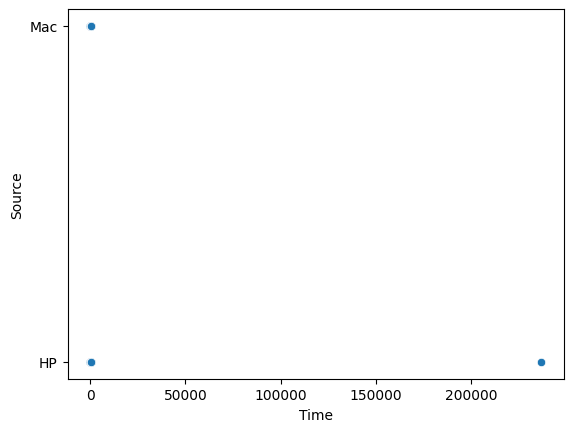

In [152]:
# Check for strong scatter between the results of time measurements
full_time = data.groupby('Source')['Time'].sum()
print("Time measurements by source:")
print(full_time)

# Create a scatter plot of the data
sns.scatterplot(data=data, x='Time', y='Source')
plt.show()

As we can see from the graph there are anomalous values.

In [153]:
# Find potential outliers
print("Potential Outliers:")
data[(data['Time'] > 1000) | (data['Time'] < 0)]

Potential Outliers:


,Experiment Index,Algorithm,Data Type,Size,Structure,Trial,Time,Source
7077,71,BubbleSortWhileNeeded,long,10000,worstCase,78,236478.5,HP


This value was most likely caused by one of the following factors and is not meaningful for further analysis.

**Possible explanations for the device error:**

1. **Hardware failure**:
   - A hardware failure or temporary malfunction may have occurred on the HP machine during the test. Issues such as overheating, memory leaks, or CPU throttling.

2. **Resource hijacking**:
   - The HP machine may have had other processes running that were competing for resources. This could be due to background tasks, updates, or other applications consuming CPU and memory resources.

3. **Measurement inaccuracy**:
   - The time measurement in this particular test may have been inaccurate due to a faulty synchronization mechanism or logging system on the HP machine, leading to an erroneous recording of the run time.

4. **Time load on the system**:
   - The HP machine may have been temporarily heavily loaded during this test, causing the algorithm to take significantly longer than normal to execute. This could be due to disk I/O bottlenecks, or other temporary system load factors.

In [154]:
# Remove the outliers
data = data[(data['Time'] < 1000) & (data['Time'] > 0)]

In [155]:
# Data Exploration after cleaning
print(data.describe())

# Save the descriptive statistics
data.describe().to_csv('descriptive_statistics.csv')

       Experiment Index          Size         Trial          Time
count      39746.000000  39746.000000  39746.000000  39746.000000
mean         112.028959   3979.243194     50.345846     64.387818
std           62.293665   4552.148393     28.871972    123.081991
min            1.000000    100.000000      1.000000      0.010000
25%           57.000000    100.000000     25.000000      0.030000
50%          114.000000   1000.000000     50.000000      1.420000
75%          167.000000  10000.000000     75.000000     69.907500
max          216.000000  10000.000000    100.000000    713.840000


---

### Data Analysis

After cleaning the data, we conduct a detailed analysis to extract meaningful insights:


- Display the number of unique trials for each category (Algorithm, Data Type, Structure, Source, Size).

In [156]:
# Function to display the number of trials for each category
def display_trial_counts(data):
  categories = ['Algorithm', 'Data Type', 'Structure', 'Source', 'Size']
  trial_counts = {category: data[category].nunique() for category in categories}
  
  for category in categories:
    unique_values = ', '.join(map(str, data[category].unique()))
    print(f'Values for {category}: {unique_values}')
  
  return trial_counts

# Display the trial counts
trial_counts = display_trial_counts(data)

# Print the trial counts in a readable format
print("\nTrial Counts:")
for category, count in trial_counts.items():
  print(f'{category}: {count}')


Values for Algorithm: BubbleSortUntilNoChange, BubbleSortWhileNeeded, QuickSortGPT, SelectionSortGPT
Values for Data Type: int, long, float, double, char, string
Values for Structure: bestCase, worstCase, averageCase
Values for Source: Mac, HP
Values for Size: 100, 1000, 10000

Trial Counts:
Algorithm: 4
Data Type: 6
Structure: 3
Source: 2
Size: 3


- Compute and display the minimum, maximum, and average execution times for each category.

In [157]:
# Function for collect min, max, and average time for each category
def display_time_stats(data):
  categories = ['Algorithm', 'Data Type', 'Structure', 'Source', 'Size']
  time_stats = data.groupby(categories)['Time'].agg(['min', 'max', 'mean']).reset_index()
  return time_stats

# Display the time statistics
time_stats = display_time_stats(data)
time_stats

,Algorithm,Data Type,Structure,Source,Size,min,max,mean
0,BubbleSortUntilNoChange,char,averageCase,HP,100,0.03,0.05,0.0314
1,BubbleSortUntilNoChange,char,averageCase,HP,1000,3.19,7.80,4.0559
2,BubbleSortUntilNoChange,char,averageCase,HP,10000,377.58,511.81,434.9868
3,BubbleSortUntilNoChange,char,averageCase,Mac,100,0.03,0.05,0.0399
4,BubbleSortUntilNoChange,char,averageCase,Mac,1000,4.06,4.84,4.2470
...,...,...,...,...,...,...,...,...
409,SelectionSortGPT,string,worstCase,HP,1000,2.84,9.90,3.7271
410,SelectionSortGPT,string,worstCase,HP,10000,311.80,412.75,339.4013
411,SelectionSortGPT,string,worstCase,Mac,100,0.02,0.03,0.0208
412,SelectionSortGPT,string,worstCase,Mac,1000,2.35,2.67,2.3892


## Performance Comparison Analysis

Lets visualize the performance of different algorithms with the help of graphs. These graphs are helpful in comparing the execution time of different algorithms, data types, and structures. 

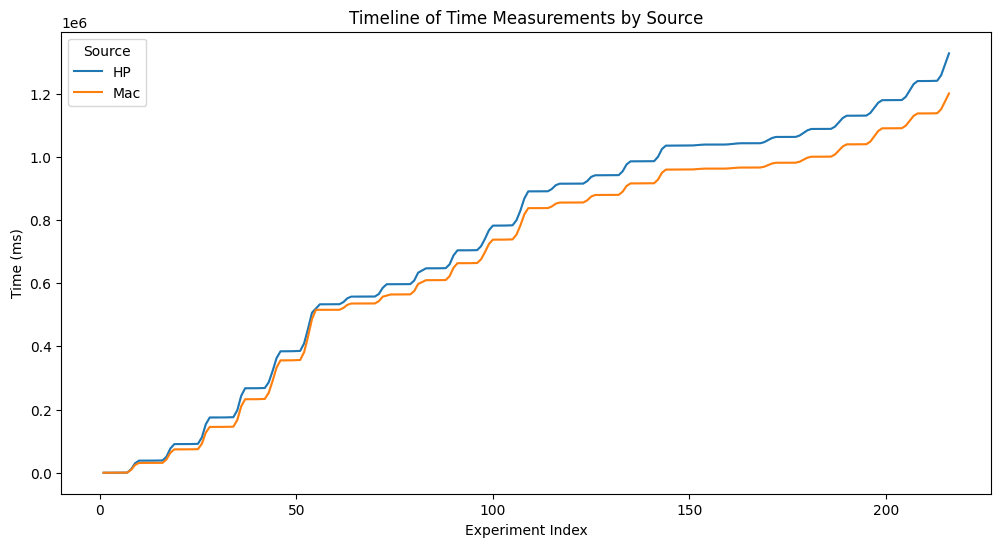

In [158]:
# Create a timeline plot of the tests performed by source
timeline_data = data.copy(deep=True)
timeline_data = timeline_data.groupby(['Experiment Index', 'Source', 'Trial'])['Time'].sum().groupby('Source').cumsum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=timeline_data, x='Experiment Index', y='Time', hue='Source')
plt.xlabel('Experiment Index')
plt.ylabel('Time (ms)')
plt.title('Timeline of Time Measurements by Source')
plt.show()

In [159]:
# Analyze the boost in performance for each device in terms of time
performance_boost = time_stats[time_stats['Source'] == 'Mac']['mean'].values[0] / time_stats[time_stats['Source'] == 'HP']['mean'].values[0]
print(f'The performance boost of the Mac over the HP is {performance_boost:.2f}x')

The performance boost of the Mac over the HP is 1.27x


1. **Median Time**

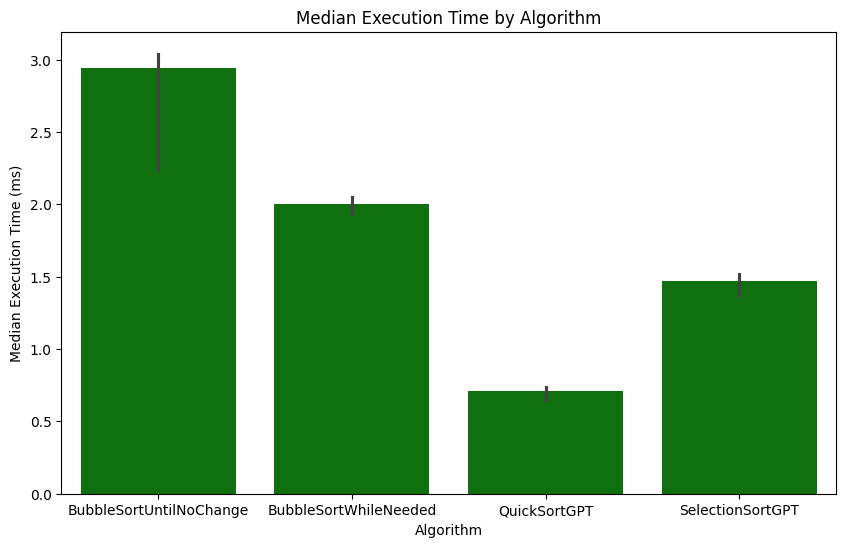

In [160]:
# Visualize the median execution time for each algorithm
import numpy as np

plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Algorithm', y='Time', estimator=np.median, color='green')
plt.title('Median Execution Time by Algorithm')
plt.xlabel('Algorithm')
plt.ylabel('Median Execution Time (ms)')
plt.show()

*Key Findings:*

- **BubbleSortWhileNeeded is faster than BubbleSortUntilNoChange**: This suggests that the optimization of stopping the sorting process when no swaps are needed improves performance.

- **QuickSortGPT and SelectionSortGPT are the fastest**: They have significantly lower median execution times, demonstrating their efficiency in sorting lists.

2. **Interquartile Range (IQR)**

In [161]:
# Interquartile range for the time taken by each algorithm
time_stats = data.groupby('Algorithm')['Time'].describe(percentiles=[0.25, 0.75])
time_stats['IQR'] = time_stats['75%'] - time_stats['25%']
time_stats

,count,mean,std,min,25%,50%,75%,max,IQR
Algorithm,,,,,,,,,
BubbleSortUntilNoChange,9644.0,108.745053,180.265367,0.01,0.04,2.94,209.2550,713.84,209.2150
BubbleSortWhileNeeded,9234.0,73.573576,119.842846,0.01,0.03,2.00,141.4175,693.48,141.3875
QuickSortGPT,10068.0,27.885391,64.074798,0.01,0.06,0.71,10.0800,338.25,10.0200
SelectionSortGPT,10800.0,50.952999,85.904603,0.01,0.02,1.47,73.9925,703.09,73.9725


3. **Comparison Across Algorithms**

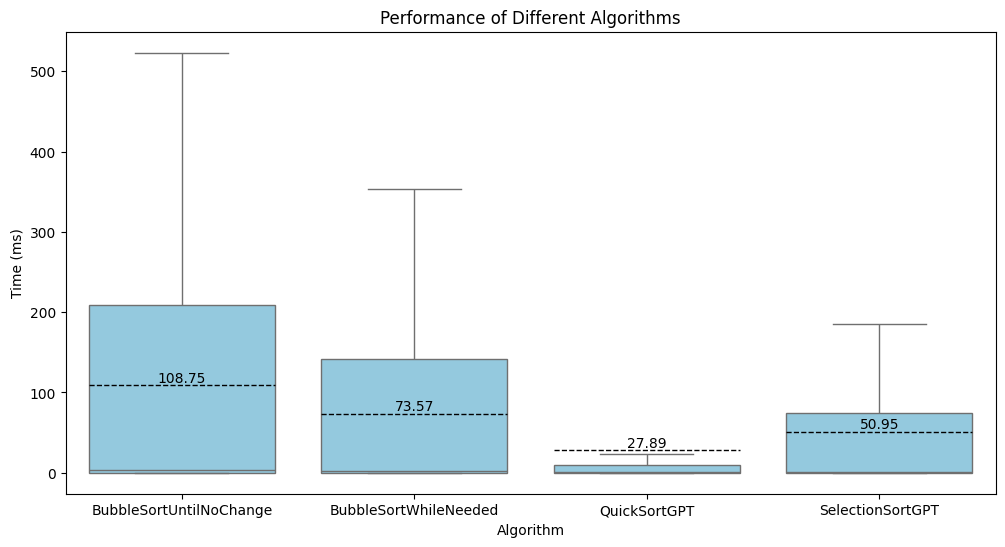

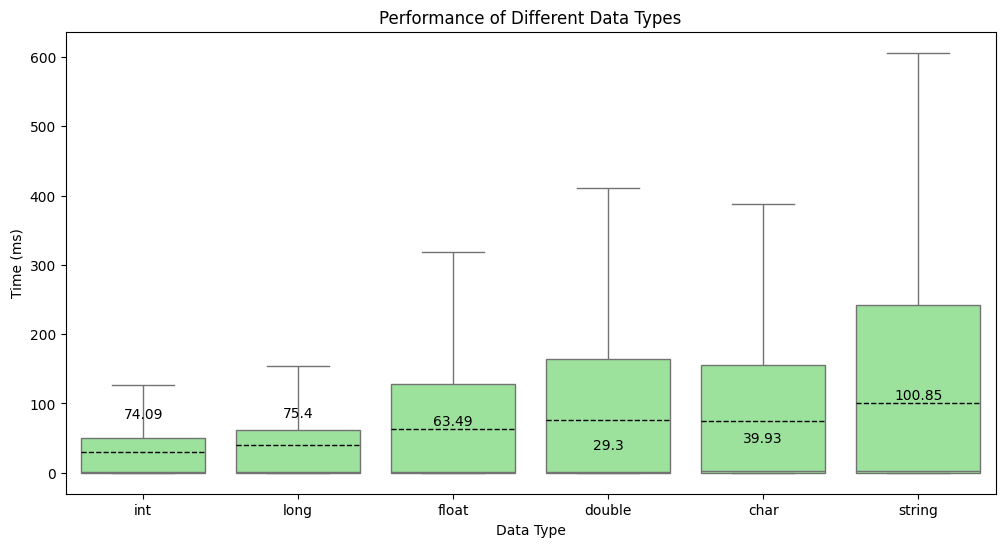

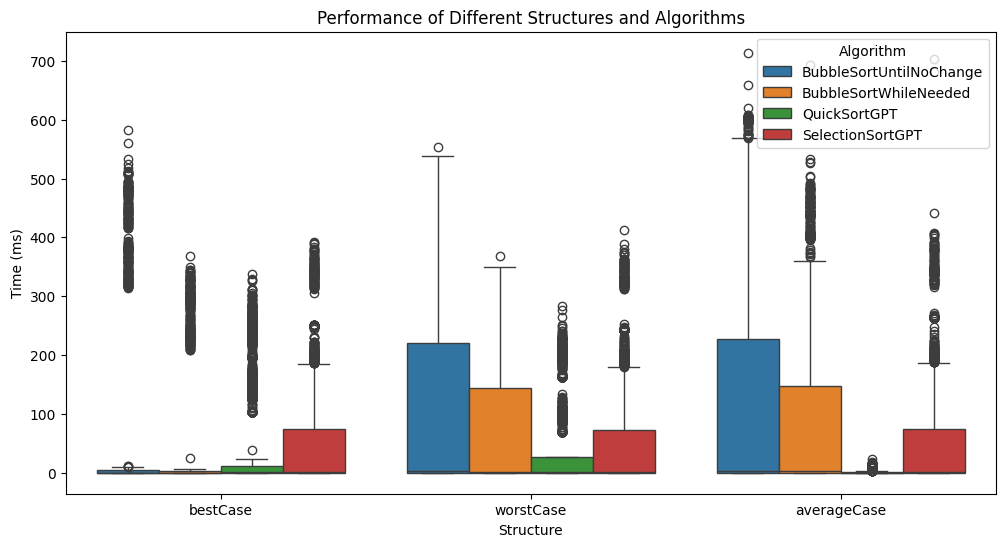

In [162]:
# Descriptive Statistics
data.groupby('Algorithm')['Time'].describe()

# Graphical Exploration

# Create a box plot to compare the performance of different algorithms
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Algorithm', y='Time', color='skyblue', showmeans=True, showfliers=False, meanline=True, meanprops={'linestyle':'--', 'color':'black'})
plt.title('Performance of Different Algorithms')
plt.ylabel('Time (ms)')

# Display mean values near the columns
means = data.groupby('Algorithm')['Time'].mean().round(2)
for i, mean in enumerate(means):
  plt.text(i, mean, f'{mean}', ha='center', va='bottom', color='black')

plt.show()

# Create a box plot to compare the performance of different data types 
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Data Type', y='Time', color='lightgreen', showmeans=True, showfliers=False, meanline=True, meanprops={'linestyle':'--', 'color':'black'})
plt.title('Performance of Different Data Types')
plt.ylabel('Time (ms)')

# Display mean values near the columns
means = data.groupby('Data Type')['Time'].mean().round(2)
for i, mean in enumerate(means):
  plt.text(i, mean, f'{mean}', ha='center', va='bottom', color='black')

plt.show()

# Create a box plot to compare the performance of different structures and algorithms
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Structure', y='Time', hue='Algorithm')
plt.title('Performance of Different Structures and Algorithms')
plt.ylabel('Time (ms)')
plt.legend(title='Algorithm', loc='upper right')

plt.show()


*Key Findings:*

**BubbleSort Algorithms:**
- **BubbleSortUntilNoChange** and **BubbleSortWhileNeeded** consistently exhibit slower performance compared to **QuickSortGPT** and **SelectionSortGPT**.
- This is particularly evident in the worst-case scenario, where BubbleSort's quadratic time complexity becomes a significant bottleneck.

**QuickSortGPT and SelectionSortGPT:**
- Generally demonstrate superior performance and greater consistency across different input scenarios.

**Integer Data Types:**
- `int` and `long` are typically faster to process than floating-point (`float`, `double`) and string data types.

**String Data Type:**
- The slowest due to its complex nature and potential overhead in memory management and string operations.

**Worst-Case Scenario:**
- BubbleSort algorithms suffer significantly, while QuickSortGPT and SelectionSortGPT maintain relatively better performance.

4. **Analysis by Input Size and Case**

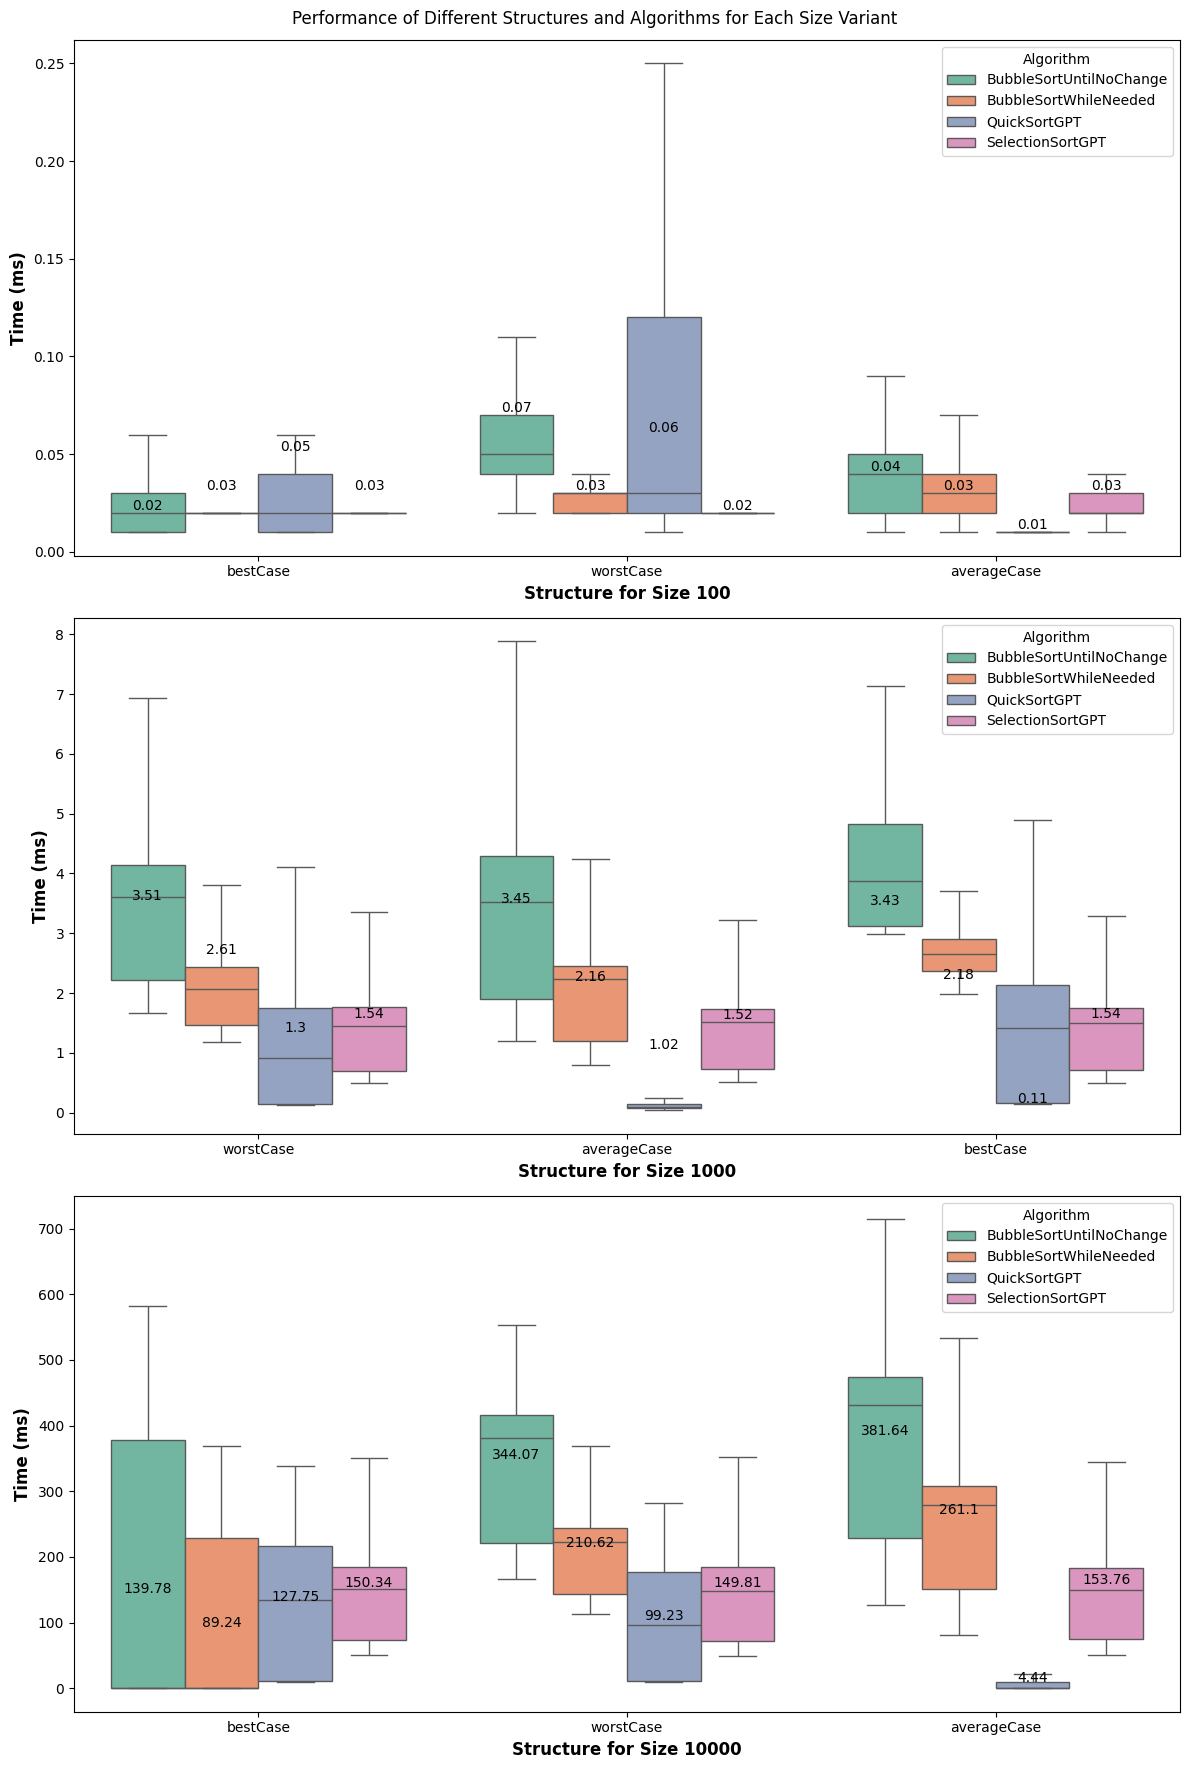

In [163]:
# Create a box plot to compare the performance of different structures and algorithms for each size variant
fig, axes = plt.subplots(nrows=len(data['Size'].unique()), ncols=1, figsize=(12, 6 * len(data['Size'].unique())))
for ax, size in zip(axes, data['Size'].unique()):
  sns.boxplot(data=data[data['Size'] == size], x='Structure', y='Time', hue='Algorithm', showfliers=False, ax=ax, palette='Set2', meanline=True, meanprops={'linestyle':'--', 'color':'black'})
  ax.set_xlabel(f'Structure for Size {size}', fontsize=12, fontweight='bold')
  ax.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
  ax.legend(title='Algorithm', loc='upper right')

  # Display mean values near the columns
  means = data[data['Size'] == size].groupby(['Structure', 'Algorithm'])['Time'].mean().round(2).reset_index()
  for index, row in means.iterrows():
    structure = row['Structure']
    algorithm = row['Algorithm']
    mean = row['Time']
    x = list(data['Structure'].unique()).index(structure) + list(data['Algorithm'].unique()).index(algorithm) * 0.2 - 0.3
    ax.text(x, mean, f'{mean}', ha='center', va='bottom', color='black')

plt.suptitle('Performance of Different Structures and Algorithms for Each Size Variant')
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

*Key Findings:*

**Size 100:**
- **Best Case**: `BubbleSortUntilNoChange` is fastest (0.02 ms). `QuickSortGPT` is slower (0.05 ms).
- **Worst Case**: `QuickSortGPT` has higher variability (0.06 ms median, up to 0.25 ms). `BubbleSortWhileNeeded` and `SelectionSortGPT` is more consistent (0.02-0.03 ms).
- **Average Case**: All algorithms perform similarly (0.01-0.04 ms).

**Size 1000:**
- **Worst Case**: `BubbleSortUntilNoChange` is slowest (3.51 ms). `QuickSortGPT` and `SelectionSortGPT` are faster (1.3 ms and 1.54 ms).
- **Average Case**: `QuickSortGPT` is fastest (1.02 ms). `BubbleSortUntilNoChange` is slowest.
- **Best Case**: `QuickSortGPT` performs best (0.11 ms). `BubbleSortUntilNoChange` is slower (3.43 ms).

**Size 10,000:**
- **Best Case**: `BubbleSortWhileNeeded` is fastest (89.24 ms). `BubbleSortUntilNoChange` is slower (139.78 ms).
- **Worst Case**: `BubbleSortUntilNoChange` is slowest (344.07 ms). `QuickSortGPT` is fastest (99.23 ms).
- **Average Case**: `QuickSortGPT` is fastest (44.41 ms).

#### Key Takeaways:
- **QuickSortGPT**: Most efficient, especially for larger datasets.
- **BubbleSortUntilNoChange**: Slowest, not suitable for large or complex datasets.
- **SelectionSortGPT and BubbleSortWhileNeeded**: Moderate performance, suitable for smaller datasets.

---


### Summary

- The analysis highlights the importance of algorithm choice and data type selection in optimizing sorting performance.
- For most practical applications, QuickSortGPT and SelectionSortGPT are generally recommended due to their efficiency and consistency.

#### General Observations:
- **QuickSortGPT**: Consistently fastest and most efficient.
- **BubbleSortUntilNoChange**: Slowest, especially in larger datasets.
- **SelectionSortGPT**: Better than BubbleSort, but not as good as QuickSortGPT.
- **BubbleSortWhileNeeded**: Moderate performance, better than `BubbleSortUntilNoChange`.

In [164]:
# Summary
data.to_csv('final_data.csv', index=False)
print('Data analysis complete!')

Data analysis complete!
